In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# загрузка файла с исходными данными
file_path = 'cian_data.csv'
data = pd.read_csv(file_path, header=None)

# добавление названий столбцов
data.columns = [
    "agency_name", "agency_type", "url", "region", "sale_type", "property_type", 
    "floor", "total_floors", "rooms", "area", "price_per_m2", "is_mortgage_possible", 
    "total_price", "district", "street", "house_number", "metro_station", "residence_name"
]

data

,agency_name,agency_type,url,region,sale_type,property_type,floor,total_floors,rooms,area,price_per_m2,is_mortgage_possible,total_price,district,street,house_number,metro_station,residence_name
0,Дипломат,developer,https://krym.cian.ru/sale/flat/292125018/,Москва и Московская область,sale,flat,2.0,8,2,66.0,-1,0,22622160,NaN,NaN,NaN,NaN,Резиденция Дипломат
1,Дипломат,developer,https://krym.cian.ru/sale/flat/292125018/,Москва и Московская область,sale,flat,2.0,8,2,66.0,-1,0,22622160,NaN,NaN,NaN,NaN,Резиденция Дипломат
2,Дипломат,developer,https://krym.cian.ru/sale/flat/292125018/,Москва и Московская область,sale,flat,2.0,8,2,66.0,-1,0,22622160,NaN,NaN,NaN,NaN,Резиденция Дипломат
3,Дипломат,developer,https://krym.cian.ru/sale/flat/292125018/,Москва и Московская область,sale,flat,2.0,8,2,66.0,-1,0,22622160,NaN,NaN,NaN,NaN,Резиденция Дипломат
4,Дипломат,developer,https://krym.cian.ru/sale/flat/292125018/,Москва и Московская область,sale,flat,2.0,8,2,66.0,-1,0,22622160,NaN,NaN,NaN,NaN,Резиденция Дипломат
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11739,VESPER,developer,https://www.cian.ru/sale/flat/286258299/,Моска и Московская область,sale,flat,5.0,9,2,104.2,-1,0,150958800,Тверской,1-я Тверская-Ямская,2,Маяковская,Vesper Tverskaya
11740,Интеллект,developer,https://krym.cian.ru/sale/flat/295983885/,Моска и Московская область,sale,flat,2.0,13,1,38.3,-1,0,12928244,NaN,NaN,NaN,NaN,Парковая Резиденция
11741,ID 85604823,unknown,https://www.cian.ru/sale/flat/308497818/,Моска и Московская область,sale,flat,16.0,41,2,51.0,-1,0,34000000,Хорошево-Мневники,Шелепихинская набережная,34к5,Шелепиха,Сердце Столицы
11742,Никита Гаврилов,realtor,https://www.cian.ru/sale/flat/308929771/,Моска и Московская область,sale,flat,5.0,17,2,60.0,-1,0,18550000,Марьино,Новочеркасский бульвар,47,Марьино,NaN


In [2]:
missing_values = data.isnull().sum()
missing_values[missing_values > 0]

agency_type              436
url                      436
region                   437
sale_type                440
property_type            440
floor                    442
total_floors             442
rooms                    442
area                     442
price_per_m2             443
is_mortgage_possible     445
total_price              447
district                3159
street                  3465
house_number            3828
metro_station           5201
residence_name          3735
dtype: int64

In [3]:
numeric_columns = ['total_price', 'area', 'rooms', 'floor', 'total_floors']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    
data_cleaned = data.copy()
data_cleaned['price_per_m2'] = data_cleaned['total_price'] / data_cleaned['area']

In [4]:
print(f"Количество записей: {len(data_cleaned)}")

Количество записей: 11744


In [5]:
data_cleaned.shape

(11744, 18)

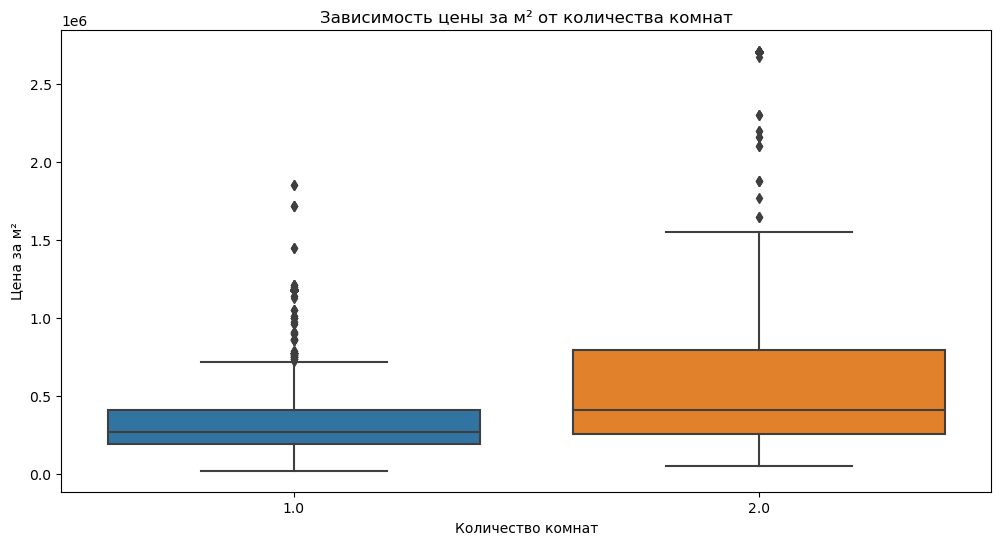

In [6]:
# 2. АНАЛИЗ КОЛИЧЕСТВА КОМНАТ
room_prices = data_cleaned.groupby('rooms')['price_per_m2'].mean()

plt.figure(figsize=(12, 6))
sns.boxplot(x='rooms', y='price_per_m2', data=data_cleaned[data_cleaned['rooms'].between(1, 4)])
plt.title('Зависимость цены за м² от количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Цена за м²')
plt.show()


In [7]:
print("СРЕДНИЕ ЦЕНЫ ЗА М² (КОМНАТЫ):")
for rooms in sorted(room_prices.index):
    if 1 <= rooms <= 4:
        print(f"{rooms}-комнатная: {room_prices[rooms]:,.0f} руб/м²")

СРЕДНИЕ ЦЕНЫ ЗА М² (КОМНАТЫ):
1.0-комнатная: 366,060 руб/м²
2.0-комнатная: 593,486 руб/м²


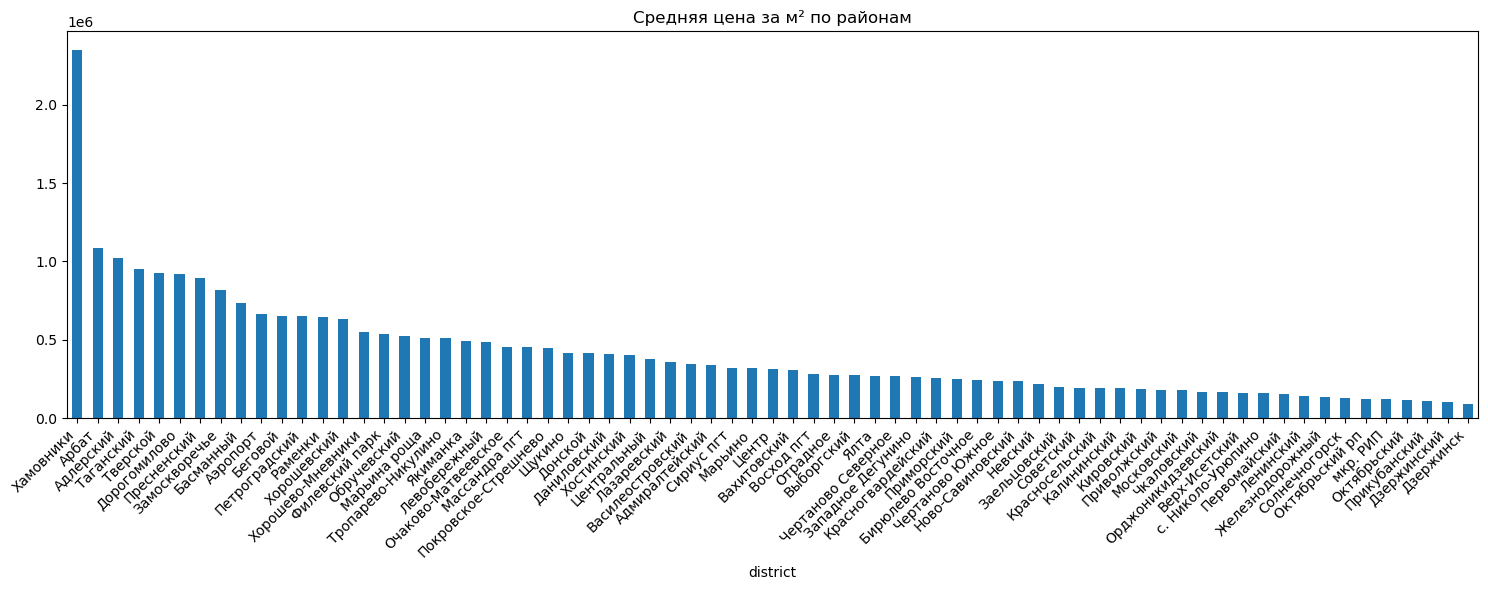

In [8]:
# 3. АНАЛИЗ РАЙОНОВ

district_stats = data_cleaned.groupby('district')['price_per_m2'].agg(['mean', 'count'])
district_stats = district_stats[district_stats['count'] > 10]  # берем районы с более чем 5 объявлениями
district_stats = district_stats.sort_values('mean', ascending=False)

plt.figure(figsize=(15, 6))
district_stats['mean'].plot(kind='bar')
plt.title('Средняя цена за м² по районам')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

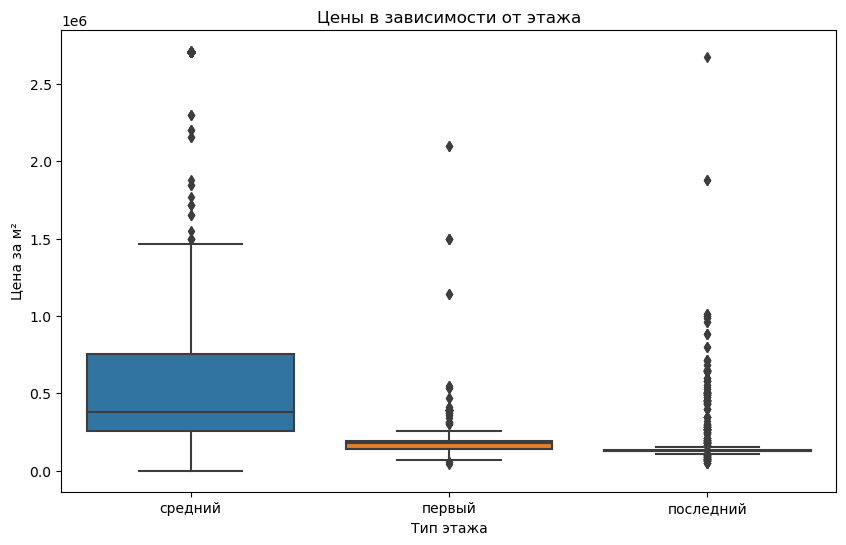

СРЕДНИЕ ЦЕНЫ ЗА М² (ЭТАЖНОСТЬ):
Первый этаж: 224,284 руб/м²
Средние этажи: 558,232 руб/м²
Последний этаж: 201,185 руб/м²


In [9]:
# 4. АНАЛИЗ ЭТАЖНОСТИ
data_cleaned['floor_type'] = 'средний'
data_cleaned.loc[data_cleaned['floor'] == 1, 'floor_type'] = 'первый'
data_cleaned.loc[data_cleaned['floor'] == data_cleaned['total_floors'], 'floor_type'] = 'последний'

floor_prices = data_cleaned.groupby('floor_type')['price_per_m2'].mean()

plt.figure(figsize=(10, 6))
sns.boxplot(x='floor_type', y='price_per_m2', data=data_cleaned)
plt.title('Цены в зависимости от этажа')
plt.xlabel('Тип этажа')
plt.ylabel('Цена за м²')
plt.show()

print("СРЕДНИЕ ЦЕНЫ ЗА М² (ЭТАЖНОСТЬ):")
print(f"Первый этаж: {floor_prices['первый']:,.0f} руб/м²")
print(f"Средние этажи: {floor_prices['средний']:,.0f} руб/м²")
print(f"Последний этаж: {floor_prices['последний']:,.0f} руб/м²")

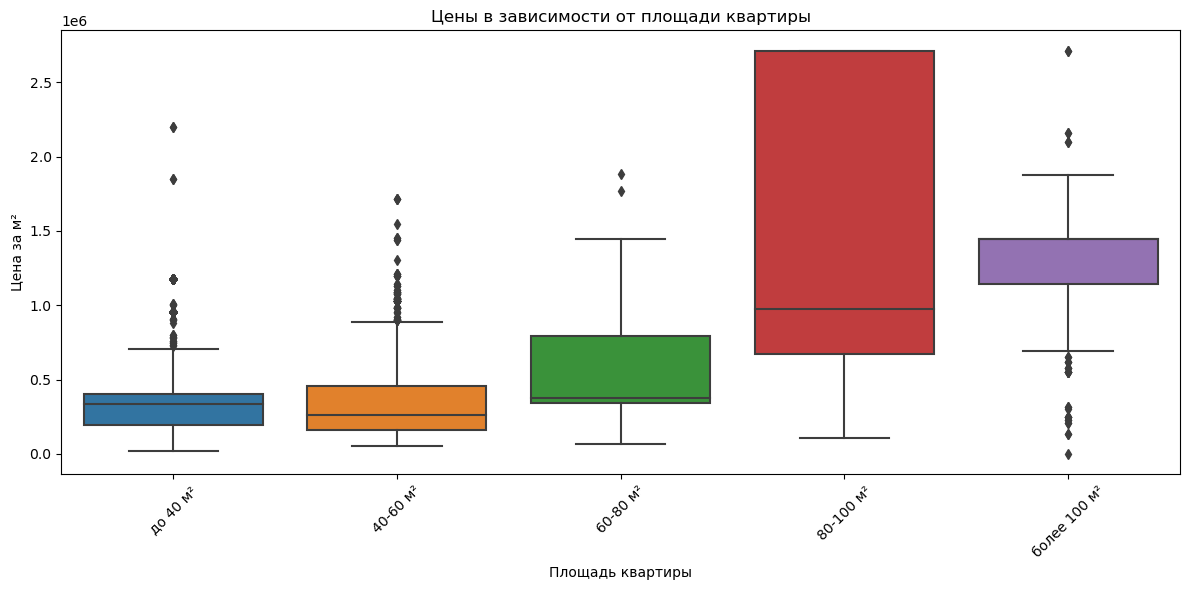

In [10]:
# 4. АНАЛИЗ ПЛОЩАДИ
# Создаем категории площади
data_cleaned['area_category'] = pd.cut(data_cleaned['area'], 
                                     bins=[0, 40, 60, 80, 100, float('inf')],
                                     labels=['до 40 м²', '40-60 м²', '60-80 м²', '80-100 м²', 'более 100 м²'])

# Считаем средние цены по категориям
area_prices = data_cleaned.groupby('area_category')['price_per_m2'].mean()

# Определяем порядок категорий
category_order = ['до 40 м²', '40-60 м²', '60-80 м²', '80-100 м²', 'более 100 м²']

# Строим график
plt.figure(figsize=(12, 6))
# Используем data_cleaned вместо data и указываем порядок категорий
sns.boxplot(x='area_category', y='price_per_m2', 
           data=data_cleaned,
           order=category_order)

# Настраиваем график
plt.title('Цены в зависимости от площади квартиры')
plt.xlabel('Площадь квартиры')
plt.ylabel('Цена за м²')
plt.xticks(rotation=45)
plt.tight_layout()  # Добавляем для лучшего отображения
plt.show()

In [11]:
data_cleaned['has_metro'] = data_cleaned['metro_station'].notna().astype(int)
metro_prices = data_cleaned.groupby('has_metro')['price_per_m2'].mean()

print("СРЕДНИЕ ЦЕНЫ ЗА М² (ПЛОЩАДЬ):")
for category in area_prices.index:
    print(f"{category}: {area_prices[category]:,.0f} руб/м²")

print("ИТОГОВЫЕ ВЫВОДЫ:")
print("1. Влияние метро:")
print(f"- Разница в цене: {(metro_prices[1] - metro_prices[0]):,.0f} руб/м²")
print(f"- Процентная надбавка: {((metro_prices[1] / metro_prices[0] - 1) * 100):.1f}%")

print("2. Разница по этажам:")
print(f"- Между средним и первым: {(floor_prices['средний'] - floor_prices['первый']):,.0f} руб/м²")
print(f"- Между средним и последним: {(floor_prices['средний'] - floor_prices['последний']):,.0f} руб/м²")

СРЕДНИЕ ЦЕНЫ ЗА М² (ПЛОЩАДЬ):
до 40 м²: 404,787 руб/м²
40-60 м²: 337,653 руб/м²
60-80 м²: 546,398 руб/м²
80-100 м²: 1,374,453 руб/м²
более 100 м²: 1,252,376 руб/м²
ИТОГОВЫЕ ВЫВОДЫ:
1. Влияние метро:
- Разница в цене: 277,680 руб/м²
- Процентная надбавка: 76.9%
2. Разница по этажам:
- Между средним и первым: 333,947 руб/м²
- Между средним и последним: 357,047 руб/м²


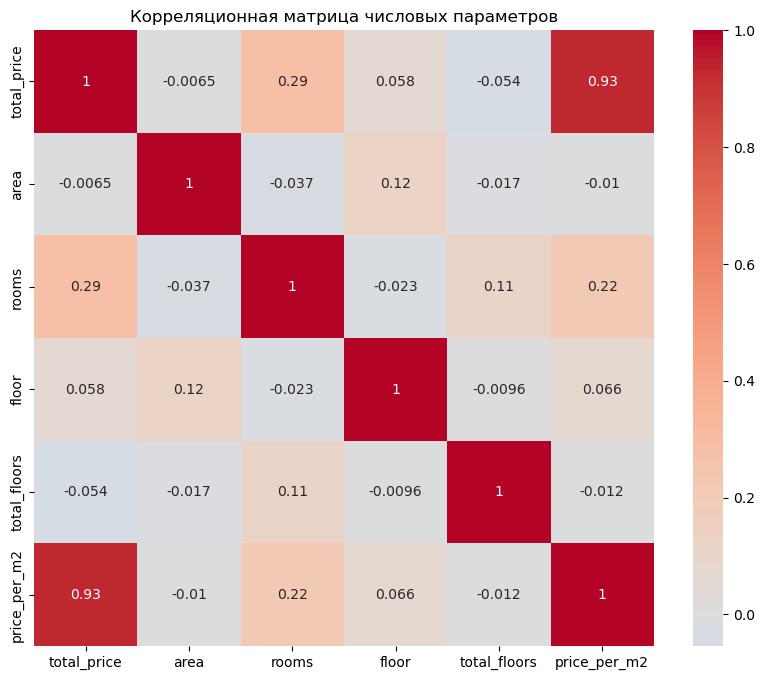

In [12]:
# КОРРЕЛЯЦИОННЫЙ АНАЛИЗ
# Создаем матрицу корреляций для числовых параметров
numeric_cols = ['total_price', 'area', 'rooms', 'floor', 'total_floors', 'price_per_m2']
correlation_matrix = data_cleaned[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица числовых параметров')
plt.show()

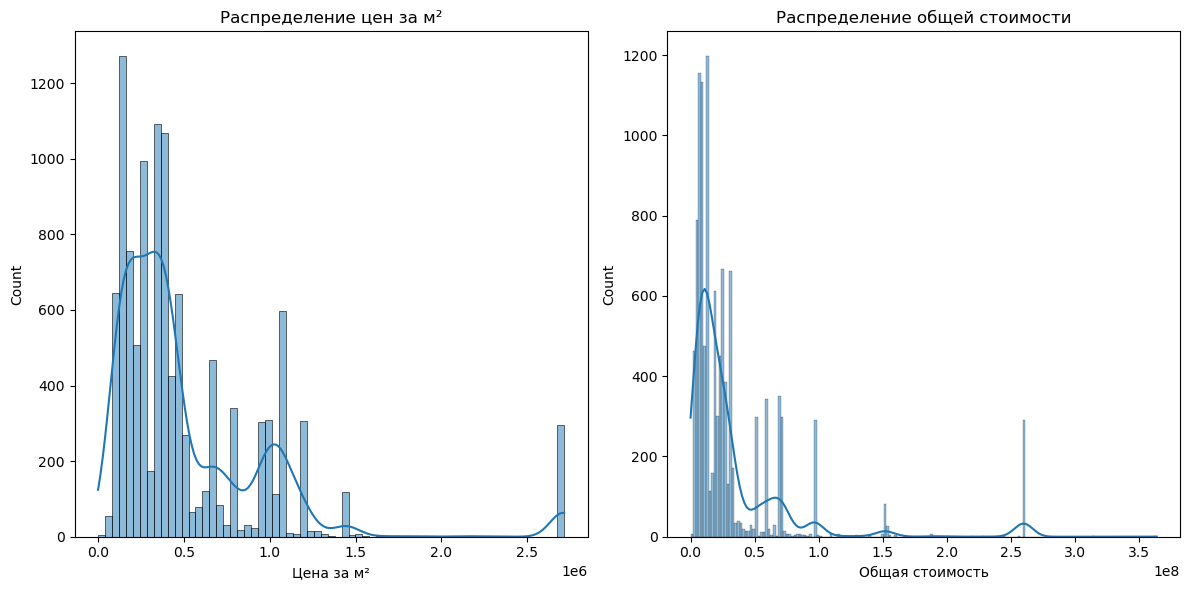

In [13]:
# РАСПРЕДЕЛЕНИЕ ЦЕН
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data_cleaned['price_per_m2'], kde=True)
plt.title('Распределение цен за м²')
plt.xlabel('Цена за м²')

plt.subplot(1, 2, 2)
sns.histplot(data_cleaned['total_price'], kde=True)
plt.title('Распределение общей стоимости')
plt.xlabel('Общая стоимость')
plt.tight_layout()
plt.show()

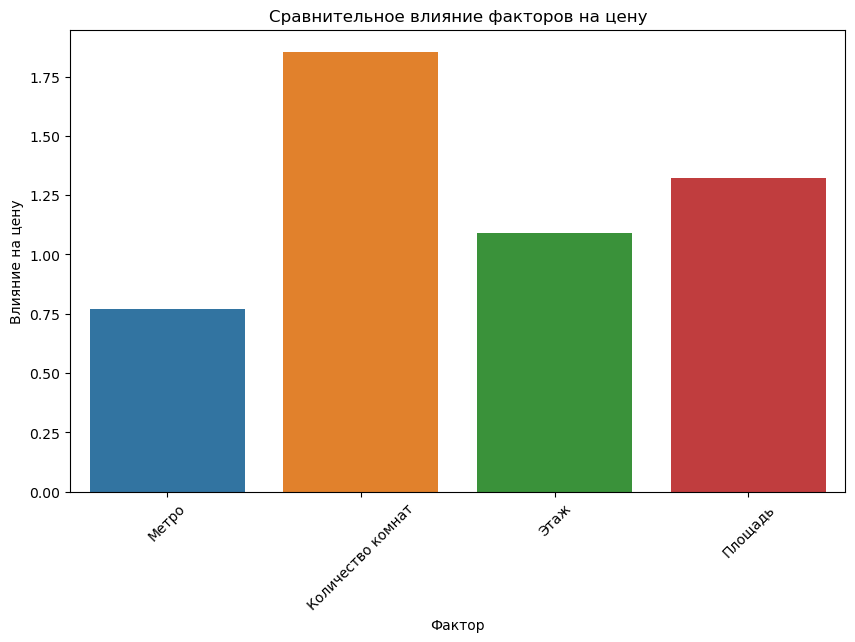

ОСНОВНЫЕ ВЫВОДЫ:
1. КОРРЕЛЯЦИИ:
- total_price и price_per_m2: 0.93
2. НАИБОЛЕЕ ЗНАЧИМЫЕ ФАКТОРЫ:
- Количество комнат: 185.6% влияния на цену
- Площадь: 132.4% влияния на цену
- Этаж: 108.9% влияния на цену
- Метро: 76.9% влияния на цену
3. РАСПРЕДЕЛЕНИЕ ЦЕН:
- Медианная цена за м²: 375,900 руб
- 25% квартир дешевле: 217,773 руб/м²
- 75% квартир дешевле: 674,432 руб/м²


In [14]:
# СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВЛИЯНИЯ ФАКТОРОВ
# Создаем DataFrame с влиянием различных факторов
factor_impact = pd.DataFrame({
    'Фактор': ['Метро', 'Количество комнат', 'Этаж', 'Площадь'],
    'Влияние на цену': [
        abs((metro_prices[1] - metro_prices[0]) / metro_prices[0]),
        abs(room_prices.max() - room_prices.min()) / room_prices.mean(),
        abs(floor_prices.max() - floor_prices.min()) / floor_prices.mean(),
        abs(area_prices.max() - area_prices.min()) / area_prices.mean()
    ]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=factor_impact, x='Фактор', y='Влияние на цену')
plt.title('Сравнительное влияние факторов на цену')
plt.xticks(rotation=45)
plt.show()
price_stats = data_cleaned['price_per_m2'].describe()

print("ОСНОВНЫЕ ВЫВОДЫ:")
print("1. КОРРЕЛЯЦИИ:")
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        corr = correlation_matrix.iloc[i,j]
        if abs(corr) > 0.3:  # выводим только значимые корреляции
            print(f"- {numeric_cols[i]} и {numeric_cols[j]}: {corr:.2f}")

print("2. НАИБОЛЕЕ ЗНАЧИМЫЕ ФАКТОРЫ:")
for idx, row in factor_impact.sort_values('Влияние на цену', ascending=False).iterrows():
    print(f"- {row['Фактор']}: {row['Влияние на цену']*100:.1f}% влияния на цену")

print("3. РАСПРЕДЕЛЕНИЕ ЦЕН:")
print(f"- Медианная цена за м²: {price_stats['50%']:,.0f} руб")
print(f"- 25% квартир дешевле: {price_stats['25%']:,.0f} руб/м²")
print(f"- 75% квартир дешевле: {price_stats['75%']:,.0f} руб/м²")



In [15]:
!pip install catboost

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder,RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [17]:
def prepare_data(data):
    df = data.copy()
    
    # Преобразуем числовые столбцы
    numeric_cols = ['floor', 'total_floors', 'area', 'rooms', 'total_price']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Вычисляем цену за метр
    df['price_per_m2'] = df['total_price'] / df['area']
    
    # Заменяем бесконечные значения на NaN
    df = df.replace([np.inf, -np.inf], np.nan)
    
    # Удаляем строки, где все важные значения - NaN
    important_cols = ['price_per_m2', 'area', 'rooms', 'floor', 'total_floors']
    df = df.dropna(subset=important_cols, how='all')
    
    # Создаем признаки
    df['has_metro'] = df['metro_station'].notna().astype(int)
    df['floor_ratio'] = df['floor'] / df['total_floors']
    df['area_per_room'] = df['area'] / df['rooms']
    
    # Обработка выбросов для числовых признаков
    numeric_features = ['floor', 'total_floors', 'area', 'area_per_room', 
                       'floor_ratio', 'price_per_m2']
    
    for col in numeric_features:
        Q1 = df[col].quantile(0.01)
        Q3 = df[col].quantile(0.99)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    
    # Заполняем оставшиеся пропуски медианами
    for col in numeric_features:
        df[col] = df[col].fillna(df[col].median())
    
    # Кодируем категориальные переменные
    le = LabelEncoder()
    categorical_columns = ['district', 'property_type']
    for col in categorical_columns:
        df[col] = le.fit_transform(df[col].fillna('Unknown'))
    
    # Проверяем, что нет бесконечных значений
    assert not np.any(np.isinf(df[numeric_features].values))
    
    features = ['district', 'floor', 'total_floors', 'floor_ratio',
                'area', 'area_per_room', 'has_metro', 'rooms', 'property_type']
    
    # Выводим информацию о данных
    print("Размер датасета после обработки:", df.shape)
    print("\nСтатистика по числовым признакам:")
    print(df[numeric_features].describe())
    
    return df[features], df['price_per_m2']

In [18]:
# Подготовка данных
X, y = prepare_data(data)

# Разделение выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Масштабирование числовых признаков
numeric_features = ['floor', 'total_floors', 'area', 'area_per_room', 'floor_ratio']
scaler = RobustScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

Размер датасета после обработки: (11302, 21)

Статистика по числовым признакам:
              floor  total_floors          area  area_per_room   floor_ratio  \
count  11302.000000  11302.000000  11302.000000   11302.000000  11302.000000   
mean       6.484693     15.698089     53.511318      32.607782      0.452517   
std        6.255725     10.095634     20.776904      11.024269      0.292624   
min        0.000000     -1.000000      0.000000      -0.000000     -1.291667   
25%        2.000000      8.000000     37.000000      24.590000      0.200000   
50%        4.000000     13.000000     49.180000      32.150000      0.363636   
75%        9.000000     20.000000     65.700000      36.800000      0.750000   
max       63.500000    101.500000    227.200000     139.500000      1.000000   

       price_per_m2  
count  1.130200e+04  
mean   5.215426e+05  
std    4.870061e+05  
min    9.285714e-07  
25%    2.181716e+05  
50%    3.759000e+05  
75%    6.744318e+05  
max    2.714809e+06  


In [19]:
# Обучение моделей
models = {
    'Random Forest': RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    ),
    'CatBoost': CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=8,
        l2_leaf_reg=3,
        verbose=False
    )
}

In [20]:
# Словарь для хранения предсказаний
predictions = {}

# Обучение и оценка моделей
for name, model in models.items():
    print(f"\nОбучение модели {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    
    # Метрики
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"\nМетрики {name}:")
    print(f"MAE: {mae:,.0f} руб/м²")
    print(f"RMSE: {rmse:,.0f} руб/м²")
    print(f"R2 Score: {r2:.3f}")


Обучение модели Random Forest...

Метрики Random Forest:
MAE: 29,977 руб/м²
RMSE: 88,317 руб/м²
R2 Score: 0.966

Обучение модели CatBoost...

Метрики CatBoost:
MAE: 16,211 руб/м²
RMSE: 43,335 руб/м²
R2 Score: 0.992


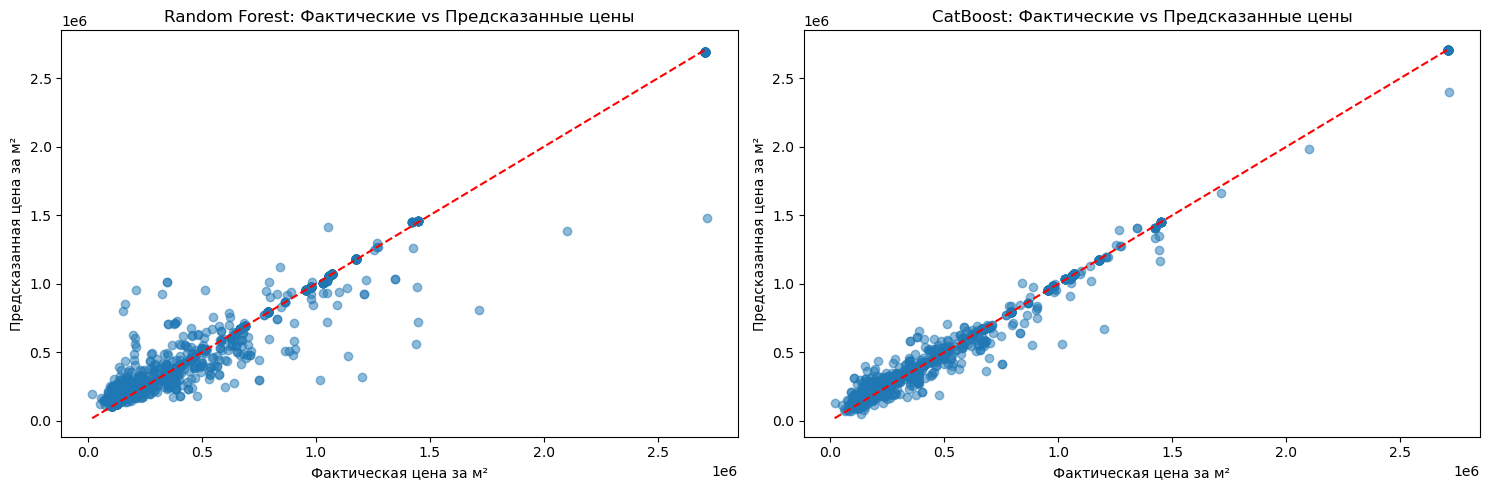

In [21]:
# Визуализация результатов
plt.figure(figsize=(15, 5))

# График для Random Forest
plt.subplot(1, 2, 1)
plt.scatter(y_test, predictions['Random Forest'], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Фактическая цена за м²')
plt.ylabel('Предсказанная цена за м²')
plt.title('Random Forest: Фактические vs Предсказанные цены')

# График для CatBoost
plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions['CatBoost'], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Фактическая цена за м²')
plt.ylabel('Предсказанная цена за м²')
plt.title('CatBoost: Фактические vs Предсказанные цены')

plt.tight_layout()
plt.show()


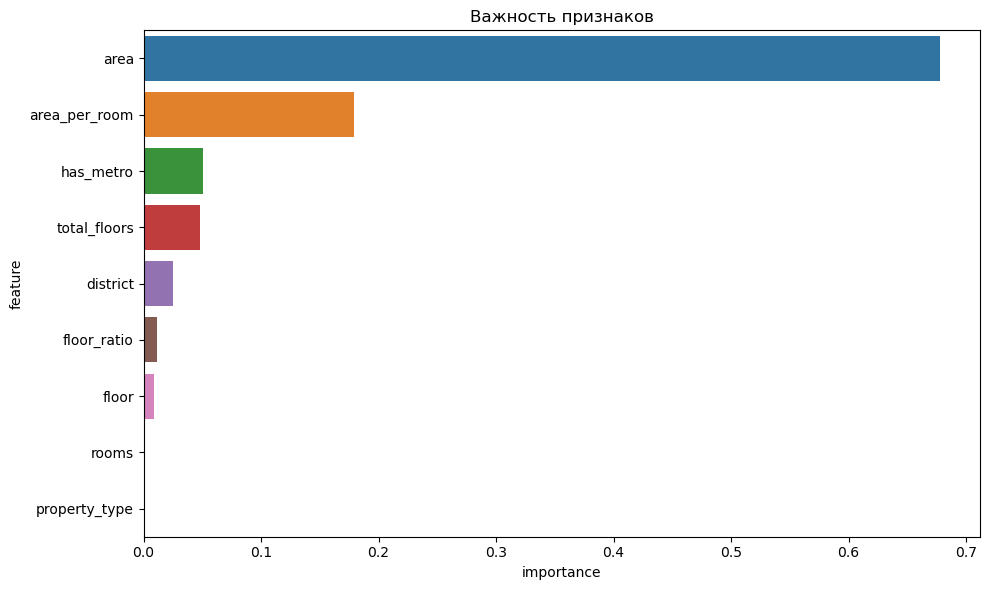

In [22]:
# Важность признаков
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': models['Random Forest'].feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Важность признаков')
plt.tight_layout()
plt.show()

In [23]:
# Примеры конкретных предсказаний
print("Примеры предсказаний (CatBoost):")
sample_indices = np.random.choice(len(y_test), 5)
for idx in sample_indices:
    actual = y_test.iloc[idx]
    predicted = predictions['CatBoost'][idx]
    print(f"Фактическая цена: {actual:,.0f} руб/м²")
    print(f"Предсказанная цена: {predicted:,.0f} руб/м²")
    print(f"Разница: {abs(actual - predicted):,.0f} руб/м²")
    print(f"Относительная ошибка: {abs(actual - predicted)/actual*100:.1f}%")

Примеры предсказаний (CatBoost):
Фактическая цена: 192,926 руб/м²
Предсказанная цена: 192,196 руб/м²
Разница: 730 руб/м²
Относительная ошибка: 0.4%
Фактическая цена: 342,760 руб/м²
Предсказанная цена: 342,893 руб/м²
Разница: 133 руб/м²
Относительная ошибка: 0.0%
Фактическая цена: 182,569 руб/м²
Предсказанная цена: 229,794 руб/м²
Разница: 47,225 руб/м²
Относительная ошибка: 25.9%
Фактическая цена: 410,000 руб/м²
Предсказанная цена: 408,763 руб/м²
Разница: 1,237 руб/м²
Относительная ошибка: 0.3%
Фактическая цена: 1,057,752 руб/м²
Предсказанная цена: 1,057,301 руб/м²
Разница: 451 руб/м²
Относительная ошибка: 0.0%


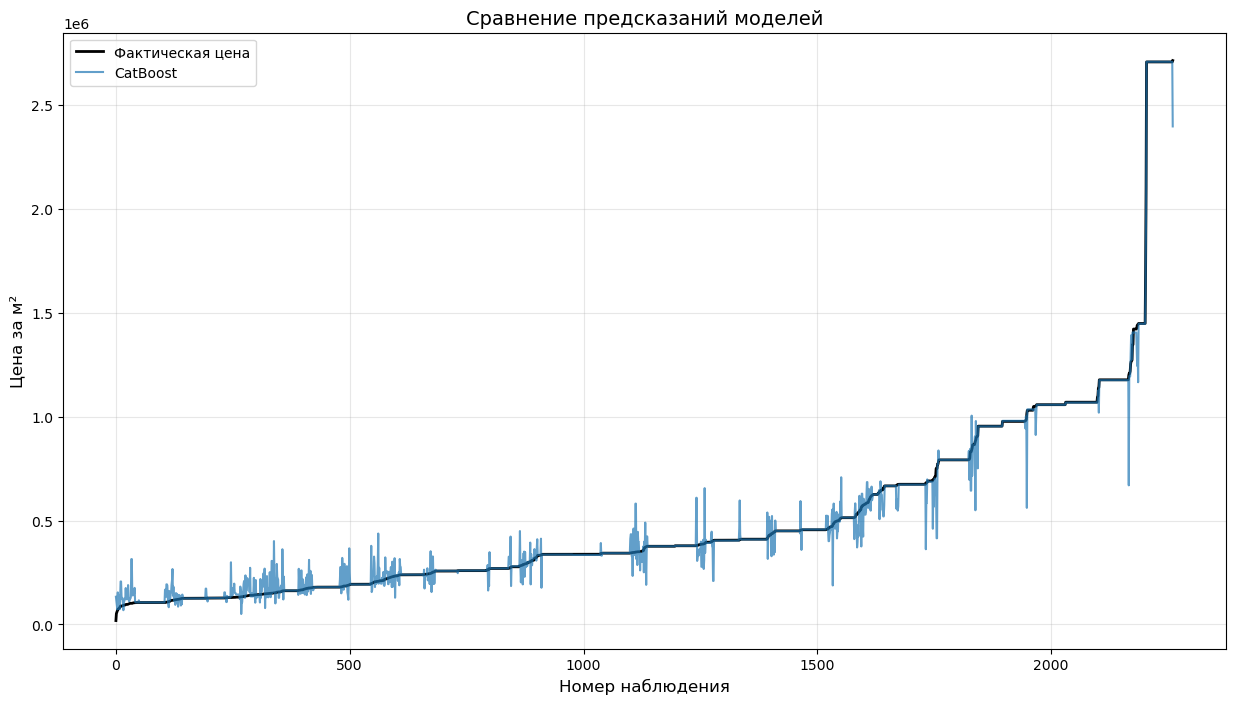

In [24]:
plt.figure(figsize=(15, 8))

# Сортируем фактические значения для построения линии
sorted_indices = np.argsort(y_test)
y_test_sorted = y_test.iloc[sorted_indices]

# Строим график
plt.plot(y_test_sorted.values, label='Фактическая цена', color='black', linewidth=2)
plt.plot(predictions['CatBoost'][sorted_indices], 
         label='CatBoost', alpha=0.7, linewidth=1.5)

plt.title('Сравнение предсказаний моделей', fontsize=14)
plt.xlabel('Номер наблюдения', fontsize=12)
plt.ylabel('Цена за м²', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)